## Import Modules

In [1]:
# Import modules

import os as os
import warnings

import sys
import time
import arviz             as az
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import numpy             as np
import pandas            as pd
from sklearn.decomposition import PCA
from scipy.interpolate import interp2d
from scipy.interpolate import RectBivariateSpline
import tensorflow as tf
import time

plt.style.use('seaborn')

np.random.seed(1234)
tf.random.set_seed(1234)

## Settings

In [2]:
domain_dim = 2    # dimension of the domain of the PDE
params_dim = 2    # number of parameters

x_0 = np.array([0.5,0.5])   # center of the force

boundary  = lambda x: 0 * x[:,0]
forcing   = lambda x: 10 * np.exp(-50 * np.sqrt( np.power(x[:,0] - x_0[0], 2) + np.power(x[:,1] - x_0[1], 2) ))

train_split = 0.9     # Tentative proportion of training points wrt validation points

on_Colab = True
my_Colab_folder = "Colab Notebooks/Keras_Experiment"

## Load data

In [3]:
if(on_Colab):
  from google.colab import drive
  drive.mount('/content/drive')

  folder = os.path.join('/content/drive/My Drive', my_Colab_folder)

if(not on_Colab):

  folder = os.getcwd()

Mounted at /content/drive


In [4]:
path_to_tables = os.path.join(folder, 'tables')

data_int = pd.read_csv (os.path.join(path_to_tables, 'tab_int.csv'), names = ('x','y','mu','theta','u'))
data_bc  = pd.read_csv (os.path.join(path_to_tables, 'tab_bc.csv' ), names = ('x','y','mu','theta','u'))

data_all = pd.concat([data_int,data_bc])

# Values of mu and theta
mus    = data_all   ['mu'].unique()
thetas = data_all['theta'].unique()


# Physical points
x_all  = data_all.loc[(data_all['mu'] == mus[0]) & (data_all['theta'] == thetas[0])][['x','y']].to_numpy()
x_int  = data_int.loc[(data_int['mu'] == mus[0]) & (data_int['theta'] == thetas[0])][['x','y']].to_numpy()
x_bc   = data_bc.loc [(data_bc ['mu'] == mus[0]) & (data_bc ['theta'] == thetas[0])][['x','y']].to_numpy()

# Dimension of the Matrix
n = x_all.shape[0]
p = len(mus) * len(thetas)

## Reshape Data

In [5]:
# Reshaped dataset and parameters
data_all_reshaped = data_all.loc[(data_all['mu'] == mus[0]) & (data_all['theta'] == thetas[0])][['u']].to_numpy()

p_all = np.array(([[mus[0],thetas[0]]]))

for mu in mus:
    for theta in thetas:
        if ((mu != mus[0]) | (theta != thetas[0])):
            
            p_current = np.array(([[mu,theta]]))
            u_current = data_all.loc[(data_all['mu'] == mu) & (data_all['theta'] == theta)][['u']].to_numpy()
            
            p_all = np.concatenate((p_all, p_current), axis = 0)
            data_all_reshaped = np.concatenate((data_all_reshaped, u_current), axis = 1)

## Build Model

In [6]:
model = tf.keras.Sequential([
                            tf.keras.layers.Dense(30, input_shape=(domain_dim+params_dim,), activation=tf.nn.tanh),
                            tf.keras.layers.Dense(30, activation=tf.nn.tanh),
                            tf.keras.layers.Dense(30, activation=tf.nn.tanh),
                            tf.keras.layers.Dense(1)
                            ])

## Build Train and Validation datasets

In [7]:
u_max = np.max(data_all['u'])
u_min = np.min(data_all['u'])
print(u_max)
print(u_min)

train_data = data_all.sample(frac=train_split)
test_data = data_all.drop(train_data.index)

train_x_p = train_data[['x','y','mu','theta']].to_numpy()
test_x_p  = test_data [['x','y','mu','theta']].to_numpy()

train_u = (train_data['u'].to_numpy() - u_min)/(u_max - u_min)
test_u = (test_data['u'].to_numpy() - u_min)/(u_max - u_min)

train_dataset = tf.data.Dataset.from_tensor_slices((train_x_p,train_u))
test_dataset = tf.data.Dataset.from_tensor_slices((test_x_p,test_u))

print('________')
print(train_data.shape)
print(test_data.shape)

0.0057748999999999995
-1.1669000000000001e-05
________
(392040, 5)
(34342, 5)


## Training

### Set number of epochs

In [8]:
ep1 = 60                # number of epochs first training
ep2 = 60                # number of epochs second training
second_train = True     # true if I want to perform two consecutive trainings

### Compile the model for the first training

In [9]:
model.compile(loss=tf.losses.mean_squared_error,
             optimizer=tf.optimizers.Adam(learning_rate=1e-3)   
             # optimizer=tf.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
             )

### First training

In [10]:
t_start = time.time()

hh1 = model.fit(x=train_x_p,
                y=train_u,
                epochs=ep1,
                batch_size=64,
                validation_data=(test_x_p,test_u))

train_time = time.time() - t_start

Epoch 1/60
6126/6126 [==============================] - 13s 2ms/step - loss: 0.0016 - val_loss: 4.9604e-04
Epoch 2/60
6126/6126 [==============================] - 12s 2ms/step - loss: 0.0011 - val_loss: 2.4185e-04
Epoch 3/60
6126/6126 [==============================] - 12s 2ms/step - loss: 7.0215e-04 - val_loss: 1.9248e-04
Epoch 4/60
6126/6126 [==============================] - 12s 2ms/step - loss: 5.7440e-04 - val_loss: 2.2032e-04
Epoch 5/60
6126/6126 [==============================] - 12s 2ms/step - loss: 4.8990e-04 - val_loss: 1.8632e-04
Epoch 6/60
6126/6126 [==============================] - 12s 2ms/step - loss: 4.1761e-04 - val_loss: 1.2602e-04
Epoch 7/60
6126/6126 [==============================] - 12s 2ms/step - loss: 3.6359e-04 - val_loss: 1.3585e-04
Epoch 8/60
6126/6126 [==============================] - 12s 2ms/step - loss: 3.2971e-04 - val_loss: 1.0382e-04
Epoch 9/60
6126/6126 [==============================] - 12s 2ms/step - loss: 3.0127e-04 - val_loss: 7.6310e-05
Epoch 10/

### Visualize results

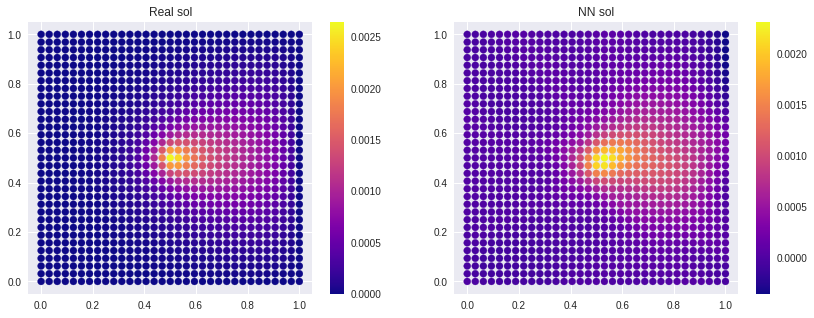

In [11]:
# select which solution to plot
sample_try = 40

p_try = np.tile(p_all[sample_try,:],(n,1))
x_p_try = np.hstack((x_all, p_try))

u_try = data_all_reshaped[:,sample_try]                     # real solution

u_recon = model.predict(x_p_try)*(u_max - u_min) + u_min    # reconstructed solution

fig, ax = plt.subplots(1,2, figsize=(14,5))
ax = ax.ravel()

im = ax[0].scatter(x_all[:,0], x_all[:,1], c=u_try, cmap='plasma')
ax[0].set_title('Real sol');
plt.colorbar(im, ax=ax[0])

im = ax[1].scatter(x_all[:,0], x_all[:,1], c=u_recon, cmap='plasma');
plt.colorbar(im, ax=ax[1])
ax[1].set_title('NN sol');

plt.savefig(os.path.join(folder,'Output'))

### Loss visualization

________________

Training Runtime: 699.0889568328857 seconds
________________


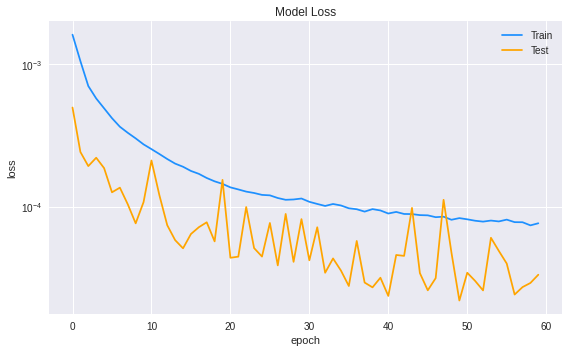

In [12]:
print('________________')
print(f'\nTraining Runtime: {train_time} seconds')
print('________________')

full_loss = hh1.history['loss']
full_val_loss = hh1.history['val_loss']

fig, ax = plt.subplots(1,1, figsize=(8,5))
ax.plot(full_loss, color='dodgerblue')
ax.plot(full_val_loss, color='orange')
ax.set_yscale('log')
ax.set_title('Model Loss')
ax.set_ylabel('loss')
ax.set_xlabel('epoch')
plt.legend(['Train', 'Test'], loc='best')

plt.tight_layout()

plt.savefig(os.path.join(folder,'Model_loss'))

### (Eventually) perform a second training

In [13]:
if second_train:

    weights = model.get_weights()

    model.compile(loss=tf.losses.mean_squared_error,
                 # optimizer=tf.optimizers.Adadelta()                 
                 # optimizer=tf.optimizers.Adam(learning_rate=1e-3)   
                  optimizer=tf.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
                 )

    model.set_weights(weights)
    
    t_start = time.time()
    
    hh2 = model.fit(x=train_x_p,
                    y=train_u,
                    epochs=ep2,
                    batch_size=64,
                    validation_data=(test_x_p,test_u))
    
    train_time = time.time() - t_start

Epoch 1/60
6126/6126 [==============================] - 10s 2ms/step - loss: 4.0441e-05 - val_loss: 1.5189e-05
Epoch 2/60
6126/6126 [==============================] - 10s 2ms/step - loss: 3.8528e-05 - val_loss: 1.3991e-05
Epoch 3/60
6126/6126 [==============================] - 10s 2ms/step - loss: 3.7916e-05 - val_loss: 1.3903e-05
Epoch 4/60
6126/6126 [==============================] - 10s 2ms/step - loss: 3.7700e-05 - val_loss: 1.3667e-05
Epoch 5/60
6126/6126 [==============================] - 10s 2ms/step - loss: 3.7483e-05 - val_loss: 1.4871e-05
Epoch 6/60
6126/6126 [==============================] - 10s 2ms/step - loss: 3.7192e-05 - val_loss: 1.3948e-05
Epoch 7/60
6126/6126 [==============================] - 11s 2ms/step - loss: 3.7036e-05 - val_loss: 1.4462e-05
Epoch 8/60
6126/6126 [==============================] - 11s 2ms/step - loss: 3.7019e-05 - val_loss: 1.4587e-05
Epoch 9/60
6126/6126 [==============================] - 10s 2ms/step - loss: 3.7026e-05 - val_loss: 1.3402e-05
E

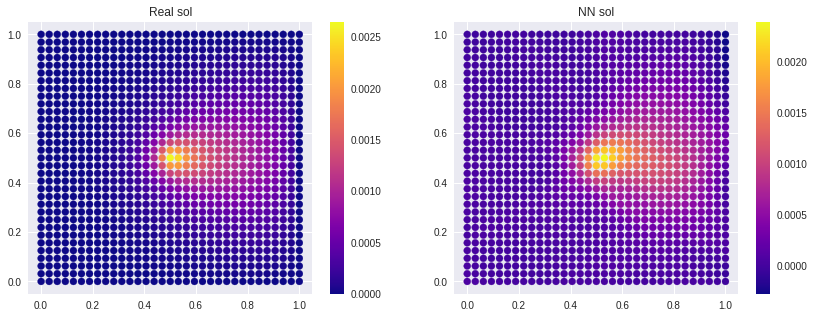

In [14]:
if second_train:

    sample_try = 40

    p_try = np.tile(p_all[sample_try,:],(n,1))
    x_p_try = np.hstack((x_all, p_try))

    u_try = data_all_reshaped[:,sample_try]

    u_recon = model.predict(x_p_try)*(u_max - u_min) + u_min

    fig, ax = plt.subplots(1,2, figsize=(14,5))
    ax = ax.ravel()

    im = ax[0].scatter(x_all[:,0], x_all[:,1], c=u_try, cmap='plasma')
    ax[0].set_title('Real sol');
    plt.colorbar(im, ax=ax[0])

    im = ax[1].scatter(x_all[:,0], x_all[:,1], c=u_recon, cmap='plasma');
    plt.colorbar(im, ax=ax[1])
    ax[1].set_title('NN sol');

    plt.savefig(os.path.join(folder,'Output_second'))

________________

Training Runtime: 607.2699768543243 seconds
________________


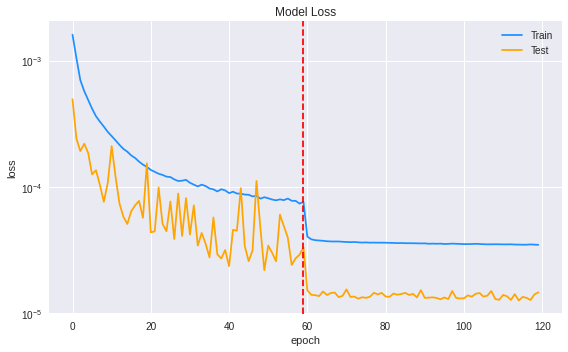

In [15]:
 if second_train:  
        
    print('________________')
    print(f'\nTraining Runtime: {train_time} seconds')
    print('________________')
    
    full_loss = hh1.history['loss'] + hh2.history['loss']
    full_val_loss = hh1.history['val_loss'] + hh2.history['val_loss']

    fig, ax = plt.subplots(1,1, figsize=(8,5))
    ax.plot(full_loss, color='dodgerblue')
    ax.plot(full_val_loss, color='orange')
    ax.axvline(x=(ep1-1), color='red', linestyle='--')
    ax.set_yscale('log')
    ax.set_title('Model Loss')
    ax.set_ylabel('loss')
    ax.set_xlabel('epoch')
    plt.legend(['Train', 'Test'], loc='best')

    plt.tight_layout()

    plt.savefig(os.path.join(folder,'Model_loss_second'))

## Save the model

In [16]:
model.save(os.path.join(folder,'red_model0'))

INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/Keras_Experiment/red_model0/assets


In [18]:
folder

'/content/drive/My Drive/Colab Notebooks/Keras_Experiment'

## Load a previously saved model

In [17]:
"""
load_model = tf.keras.models.load_model('red_model04')

sample_try = 40
print(p_all[sample_try,:])
p_try = np.tile(p_all[sample_try,:],(n,1))
x_p_try = np.hstack((x_all, p_try))

u_try = data_all_reshaped[:,sample_try]

u_recon = load_model.predict(x_p_try)*(u_max - u_min) + u_min

fig, ax = plt.subplots(1,2, figsize=(14,5))
ax = ax.ravel()

im = ax[0].scatter(x_all[:,0], x_all[:,1], c=u_try, cmap='plasma')
ax[0].set_title('Real sol');
plt.colorbar(im, ax=ax[0])

im = ax[1].scatter(x_all[:,0], x_all[:,1], c=u_recon, cmap='plasma');
plt.colorbar(im, ax=ax[1])
ax[1].set_title('NN sol');

plt.savefig(os.path.join(folder,'Output'))

"""

"\nload_model = tf.keras.models.load_model('red_model04')\n\nsample_try = 40\nprint(p_all[sample_try,:])\np_try = np.tile(p_all[sample_try,:],(n,1))\nx_p_try = np.hstack((x_all, p_try))\n\nu_try = data_all_reshaped[:,sample_try]\n\nu_recon = load_model.predict(x_p_try)*(u_max - u_min) + u_min\n\nfig, ax = plt.subplots(1,2, figsize=(14,5))\nax = ax.ravel()\n\nim = ax[0].scatter(x_all[:,0], x_all[:,1], c=u_try, cmap='plasma')\nax[0].set_title('Real sol');\nplt.colorbar(im, ax=ax[0])\n\nim = ax[1].scatter(x_all[:,0], x_all[:,1], c=u_recon, cmap='plasma');\nplt.colorbar(im, ax=ax[1])\nax[1].set_title('NN sol');\n\nplt.savefig(os.path.join(folder,'Output'))\n\n"